In [213]:
import hashlib
import threading
import random
import math
import string
import networkx as nx
import matplotlib as plt
import time

In [214]:
def generate_random_string(length):
        letters = string.ascii_lowercase
        rand_string = ''.join(random.choice(letters) for i in range(length))
        return rand_string

In [215]:
class vertex:
    def __init__(self, size, num):
        self.ring_size = size
        self.id = num
        self.fingers_ids = []
        self.fingers = []
        self.files = []
        self.successor = self
        
    def find_successor(self, goal):
        if (self.id < goal) + (goal <= self.successor.id) + (self.successor.id < self.id) >= 2:
            return self.successor
        else:
            node = self.closest_preceding_node(goal)
            return node.find_successor(goal)
        
    def find_file(self, goal, path = [], depth=0):
        path.append(self.id)
        if goal in self.files:
            return 1, depth
        if ((self.id < goal) + (goal <= self.successor.id) + (self.successor.id < self.id) >= 2 or goal in self.successor.files):
            if goal in self.successor.files:
                return 1, depth+1
            else:
                return 0, depth+1
            return self.successor
        else:
            node = self.closest_preceding_node(goal)
            return node.find_file(goal, path, depth+1)
        

    def closest_preceding_node(self, goal):
        for i in range(self.ring_size-1, -1, -1):
            if (self.id < self.fingers[i].id) + (self.fingers[i].id < goal) + (goal < self.id) >= 2:
                return self.fingers[i]
        return self.successor

In [216]:
class graph:
    def __init__(self, n):
        self.ring_size = 2* int(math.log(n, 2))
        self.vertexes_cnt = n
        self.id_to_node = {}
        self.build_graph()
        self.fix_fingers()
        self.move_files()
    
    def generate_vertexes(self):
        ring = [0]*(2**self.ring_size)
        for i in range(self.vertexes_cnt):
            host = graph.ip_generator()
            ring[graph.get_id(host, int(2**self.ring_size))] = 1
        return ring
        
    def build_graph(self):
        vertexes_place = self.generate_vertexes()
        self.vertexes = []
        for i in range(int(2**self.ring_size)):
            if vertexes_place[i] == 1:
                new_node = vertex(self.ring_size, i)
                self.vertexes.append(new_node)
                self.id_to_node[i] = new_node
                idx = len(self.vertexes)-1
                for num in range(self.ring_size):
                    j = (i + int(2**num))% int(2**self.ring_size)
                    while vertexes_place[j] != 1:
                        j = (j + 1) % int(2**self.ring_size)
                    self.vertexes[idx].fingers_ids.append(j) 
                self.vertexes[idx].files = graph.files_generator(int(2**self.ring_size))
        
    def fix_fingers(self):
        for v in self.vertexes:
            for finger in v.fingers_ids:
                v.fingers.append(self.id_to_node[finger])
            v.successor = v.fingers[0]
    
    def move_files(self):
        for v in self.vertexes:
            res = []
            for file in v.files:
                node = v.find_successor(file)
                res.append(file)
            if(node):
                node.files += res
    
    
    def get_id(st, mod):
        string = str(st)
        return int(hashlib.sha1(string.encode()).hexdigest(), 16) % mod
        
    def ip_generator():
        a = random.randint(0,255)
        b = random.randint(0,255)
        c = random.randint(0,255)
        d = random.randint(0,255)
        return str(a)+'.'+str(b)+'.'+str(c)+'.'+str(d)
        
    def files_generator(mod):
        files = []
        cnt = random.randint(0, 50)
        for i in range(cnt):
            length = random.randint(0, 50)
            file_name = generate_random_string(length)
            file = graph.get_id(file_name, mod)
            files.append(graph.get_id(file, mod))
        return files

In [217]:
def send_queries(G, queries_cnt):
    min_depth = 1000000000
    max_depth = 0
    average_depth = 0
    were_found = 0
    for vertex in G.vertexes:
        for query in range(queries_cnt):
            length = random.randint(0, 50) 
            file_to_find = generate_random_string(length)
            was_found, depth = vertex.find_file(graph.get_id(file_to_find, 2**(vertex.ring_size)))
            min_depth = min(min_depth, depth)
            max_depth = max(max_depth, depth)
            average_depth += depth
            were_found += was_found
        average_depth /= queries_cnt
    return min_depth, max_depth, average_depth, were_found

In [218]:
def check_amount_information(G):
    min_amount_files = 1000000000
    max_amount_files = 0
    average_amount_files = 0
    
    min_amount_fingers = 1000000000
    max_amount_fingers = 0
    average_amount_fingers = 0
    
    for vertex in G.vertexes:
        files_cnt = len(vertex.files)
        min_amount_files = min(min_amount_files, files_cnt)
        max_amount_files = max(max_amount_files, files_cnt)
        average_amount_files += files_cnt
    
        fingers_cnt = len(vertex.fingers)
        min_amount_fingers = min(min_amount_fingers, fingers_cnt)
        max_amount_fingers = max(max_amount_fingers, fingers_cnt)
        average_amount_fingers += fingers_cnt
        
    files_info = [min_amount_files, max_amount_files, average_amount_files/len(G.vertexes)]
    fingers_info = [min_amount_fingers, max_amount_fingers, average_amount_fingers/len(G.vertexes)]
        
    return files_info, fingers_info 

In [220]:
def graph_visualization(G, path = []):
    gr = nx.DiGraph()
    sorted(G.vertexes, key=lambda n: n.id)
    for vertex in G.vertexes:
        gr.add_edge(vertex.id, vertex.successor.id)
        for finger in vertex.fingers:
            gr.add_edge(vertex.id, finger.id)
    nodes = {}
    edges = {}
    idx = 0
    for node in gr.nodes:
        nodes[node] = idx
        idx += 1
    print(type(gr.edges))
    node_colors = ['red']*(len(gr.nodes))
    edge_colors = ['black']*(len(gr.edges))
    nx.draw_circular(gr, with_labels = True, node_color=node_colors, edge_color=edge_colors)
    
    for i in range(len(path) - 1):
        print(path[i])
        node_colors[nodes[path[i]]] = 'green'
        nx.draw_circular(gr, with_labels = True, node_color=node_colors, edge_color=edge_colors)
        

In [221]:
G = graph(1000)

In [222]:
files_info, fingers_info  = check_amount_information(G)

print("минимальный объем хранимой информации на узле = ", files_info[0], "файлов и ", fingers_info[0], "исходящих дуг")
print("максимальный объем хранимой информации на узле = ", files_info[1], "файлов и ", fingers_info[1], "исходящих дуг")
print("средний показатель объема хранимой информации на узле = ", files_info[2], "файлов и ", fingers_info[2], "исходящих дуг")

минимальный объем хранимой информации на узле =  0 файлов и  18 исходящих дуг
максимальный объем хранимой информации на узле =  510 файлов и  18 исходящих дуг
средний показатель объема хранимой информации на узле =  60.81945837512538 файлов и  18.0 исходящих дуг


In [223]:
queries_count = 1000

min_depth, max_depth, average_depth, were_found = send_queries(G, queries_count)
print()

print("минимальная длина пути ", min_depth, "хопов")
print("максимальная длина пути ", max_depth, "хопов")
print("средняя длина пути ", average_depth, "хопов")


минимальная длина пути  0 хопов
максимальная длина пути  11 хопов
средняя длина пути  5.802735734781731 хопов


In [224]:
visual_graph = graph(50)

In [225]:
depth = 0;
while not depth == 6:
    vertex = visual_graph.vertexes[0]
    file_to_find = generate_random_string(15)
    path = []
    was_found, depth = vertex.find_file(graph.get_id(file_to_find, 2**(vertex.ring_size)), path)
    print(path)

[18, 276, 418]
[18, 276, 358]
[18, 549, 715, 731, 738]
[18, 276, 418, 441, 442]
[18, 21]
[18, 276, 418]
[18, 549, 715, 756, 770]
[18, 549]
[18]
[18, 151]
[18, 276, 298, 301]
[18, 276, 418, 441, 442]
[18, 549]
[18, 549, 715, 791]
[18, 549, 811, 835]
[18, 151, 191, 196]
[18]
[18, 151]
[18, 276]
[18, 276, 298, 301]
[18, 549, 811, 835]
[18, 96]
[18, 549, 811, 951]
[18, 151]
[18, 549, 715, 791]
[18, 549, 811, 951, 990]
[18, 549, 624]
[18, 21]
[18, 54, 63, 68]
[18, 151, 191, 196]
[18, 549, 715, 791]
[18, 276, 358, 374, 389]
[18, 549]
[18, 549, 811, 835]
[18, 549, 811, 875, 911, 927]


In [226]:
print(path)

[18, 549, 811, 875, 911, 927]


<class 'networkx.classes.reportviews.OutEdgeView'>
18
549
811
875
911


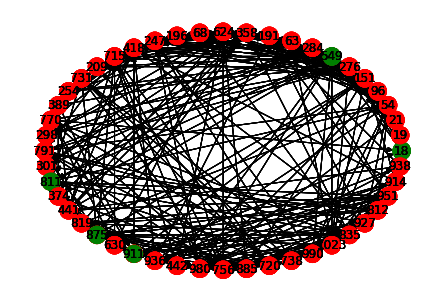

In [227]:
graph_visualization(visual_graph, path)